In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import segmentation, color
import skimage

In [58]:
def return_colors(image):
    unique_colors = np.unique(image.reshape(-1, 3), axis=0)
    return unique_colors


def euclidean_distance(color1, color2):
    # Convert colors to numpy arrays of type float for accurate calculation
    return np.sqrt(np.sum((np.array(color1, dtype=float) - np.array(color2, dtype=float)) ** 2))


def find_closest_colors(image_colors, paint_colors):
    closest_colors = []
    for image_color in image_colors:
        # Ensure RGB values are in a suitable numerical format
        image_color = np.array(image_color, dtype=float)
        distances = [euclidean_distance(image_color, np.array(paint_color, dtype=float)) for paint_color in
                     paint_colors]
        closest_color_index = np.argmin(distances)
        closest_colors.append(paint_colors[closest_color_index])
    return closest_colors


In [61]:
img = skimage.io.imread("../images/buc.jpeg")

#img_blur = cv2.medianBlur(img, 15)
#img_blur = cv2.GaussianBlur(img,(21,21),0)

labels1 = segmentation.slic(img, compactness=30, n_segments=5000, start_label=0)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=1)


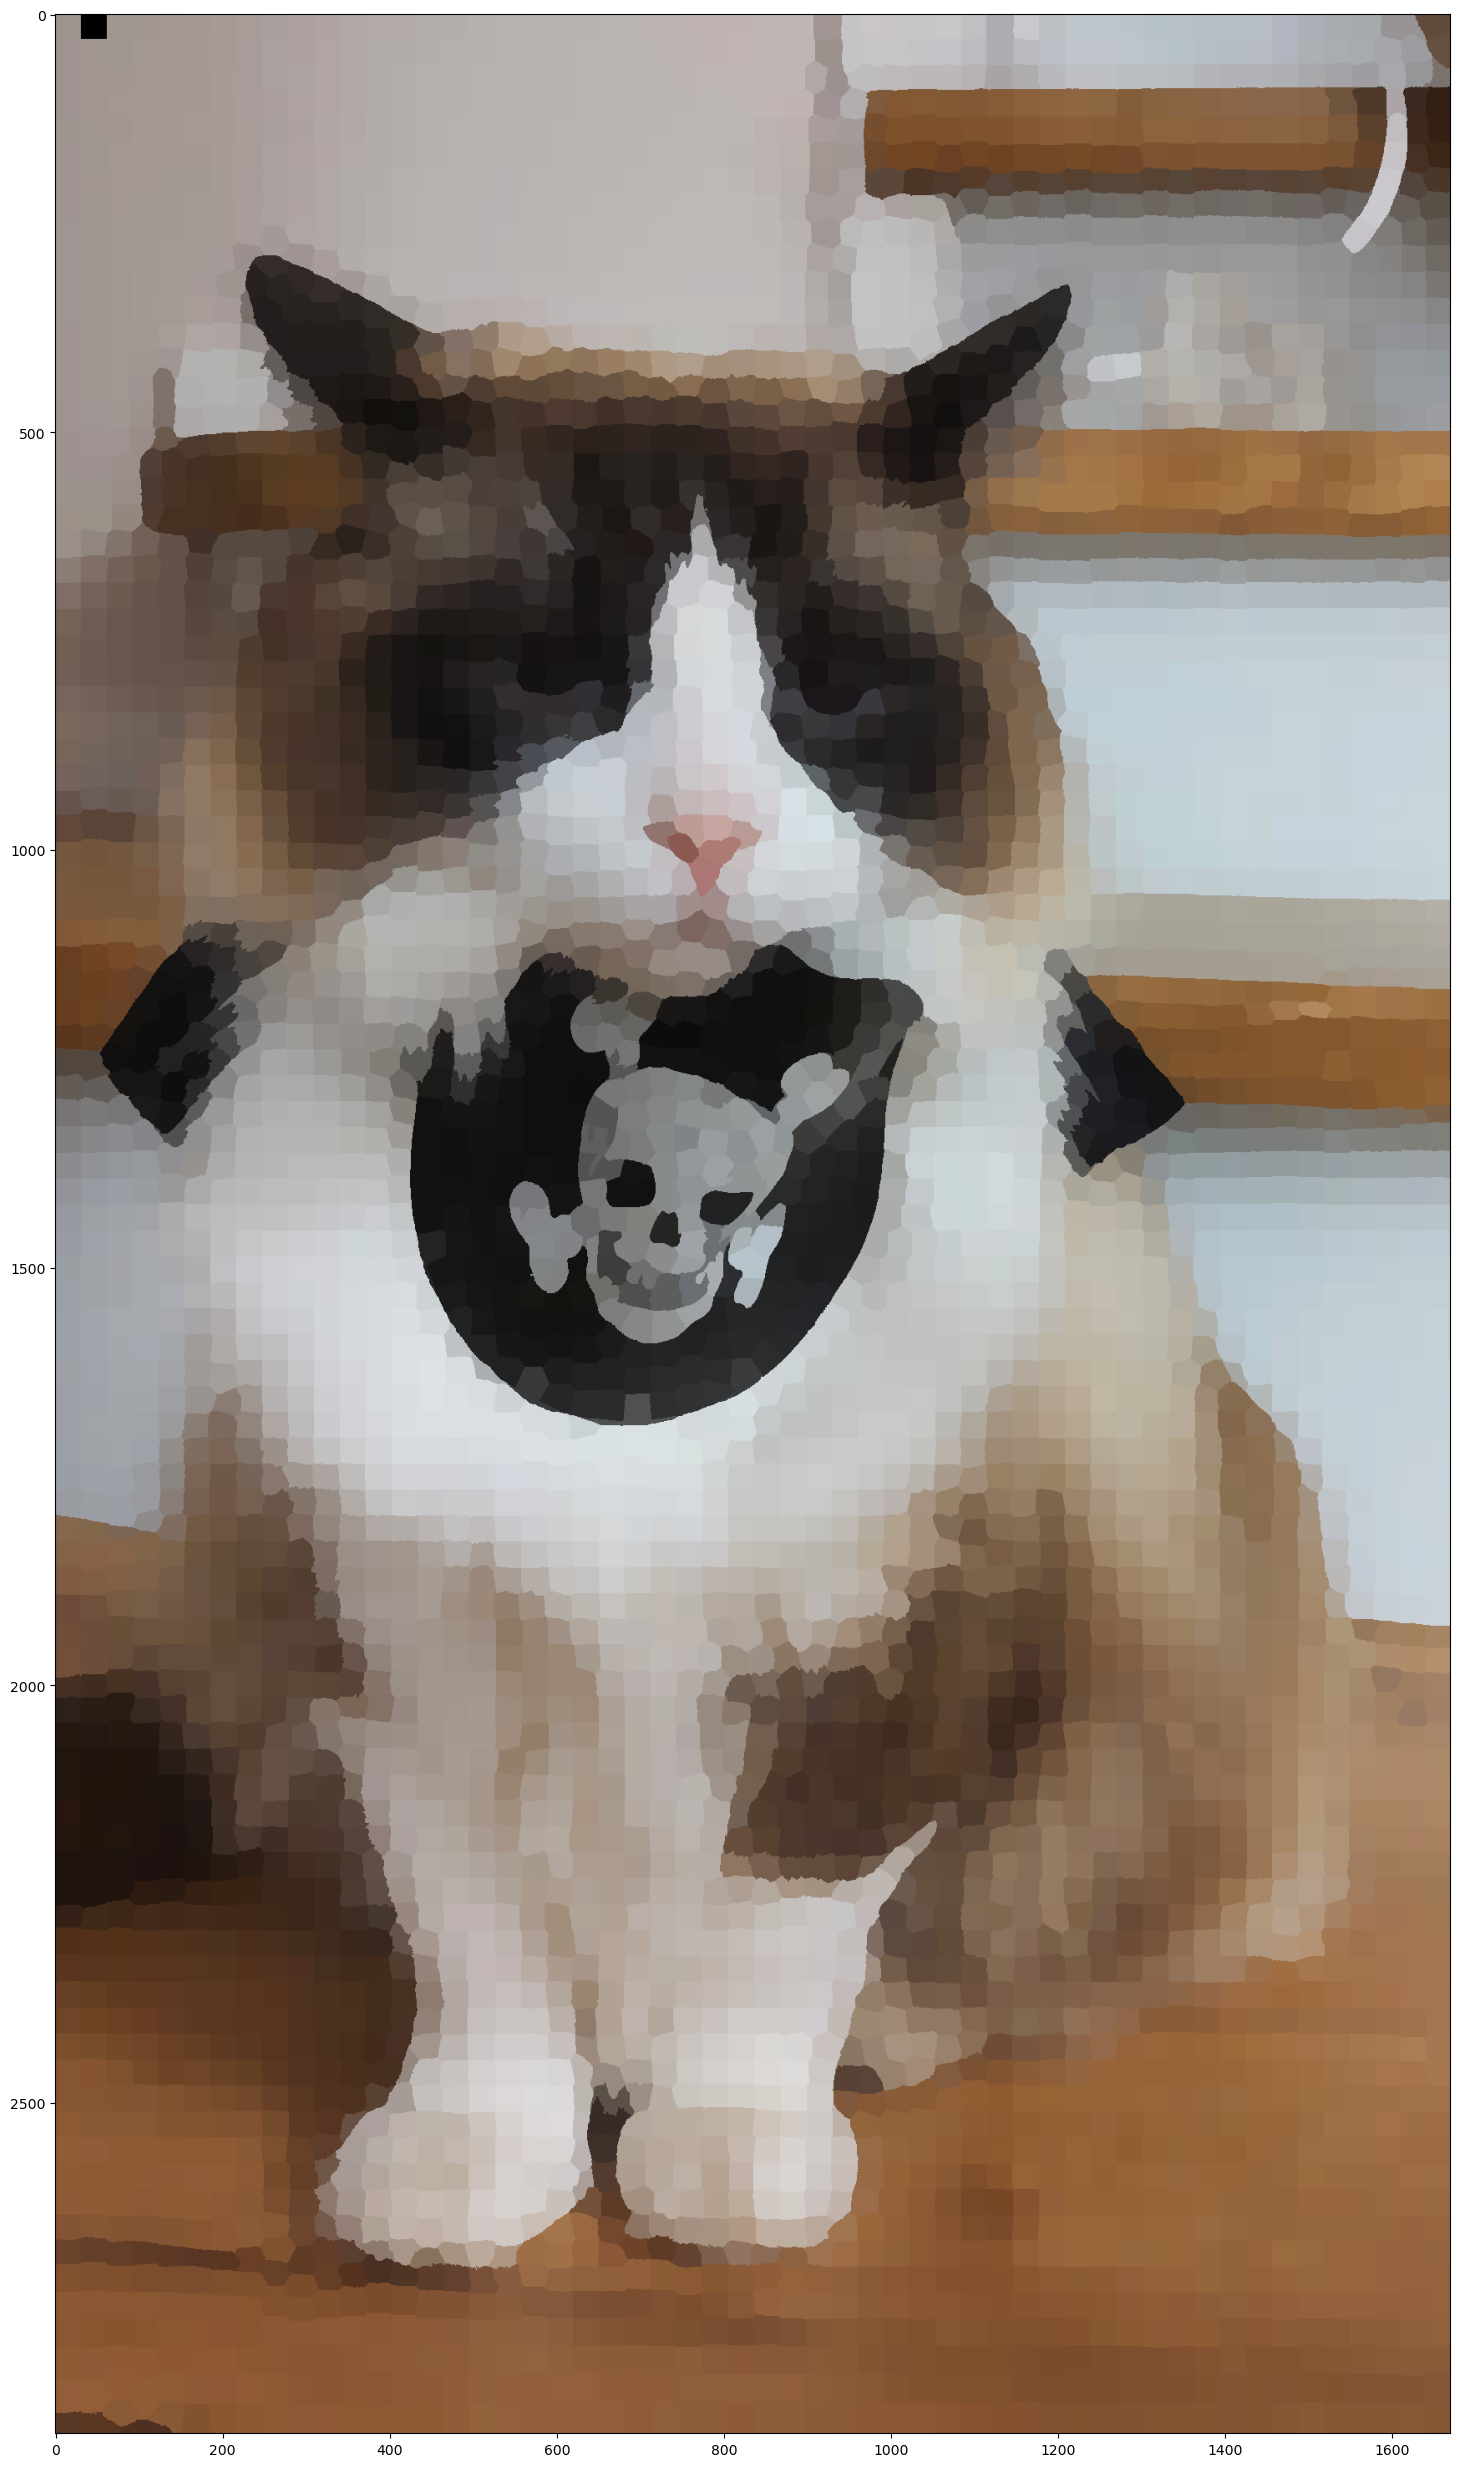

In [62]:
plt.figure(figsize=(18, 32))
plt.imshow(out1)

In [63]:
#noiseless_image = cv2.fastNlMeansDenoisingColored(out1,None,30,30,21,41)

#noiseless_image = cv2.GaussianBlur(out1,(5,5),0)
noiseless_image = cv2.medianBlur(out1, 11)

vectorized = out1.reshape((-1, 3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 17  # (default = 17)
attempts = 10
ret, label, center = cv2.kmeans(vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)

res = center[label.flatten()]
result_image = res.reshape(img.shape)
#result_image = cv2.GaussianBlur(result_image,(5,5),0)

#noiseless_image_colored = cv2.fastNlMeansDenoisingColored(result_image,None,20,20,7,21)

#result = cv2.imwrite('../images/duzo_blurra.jpg', result_image)


In [ ]:
img = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('lovebuc.png', img)

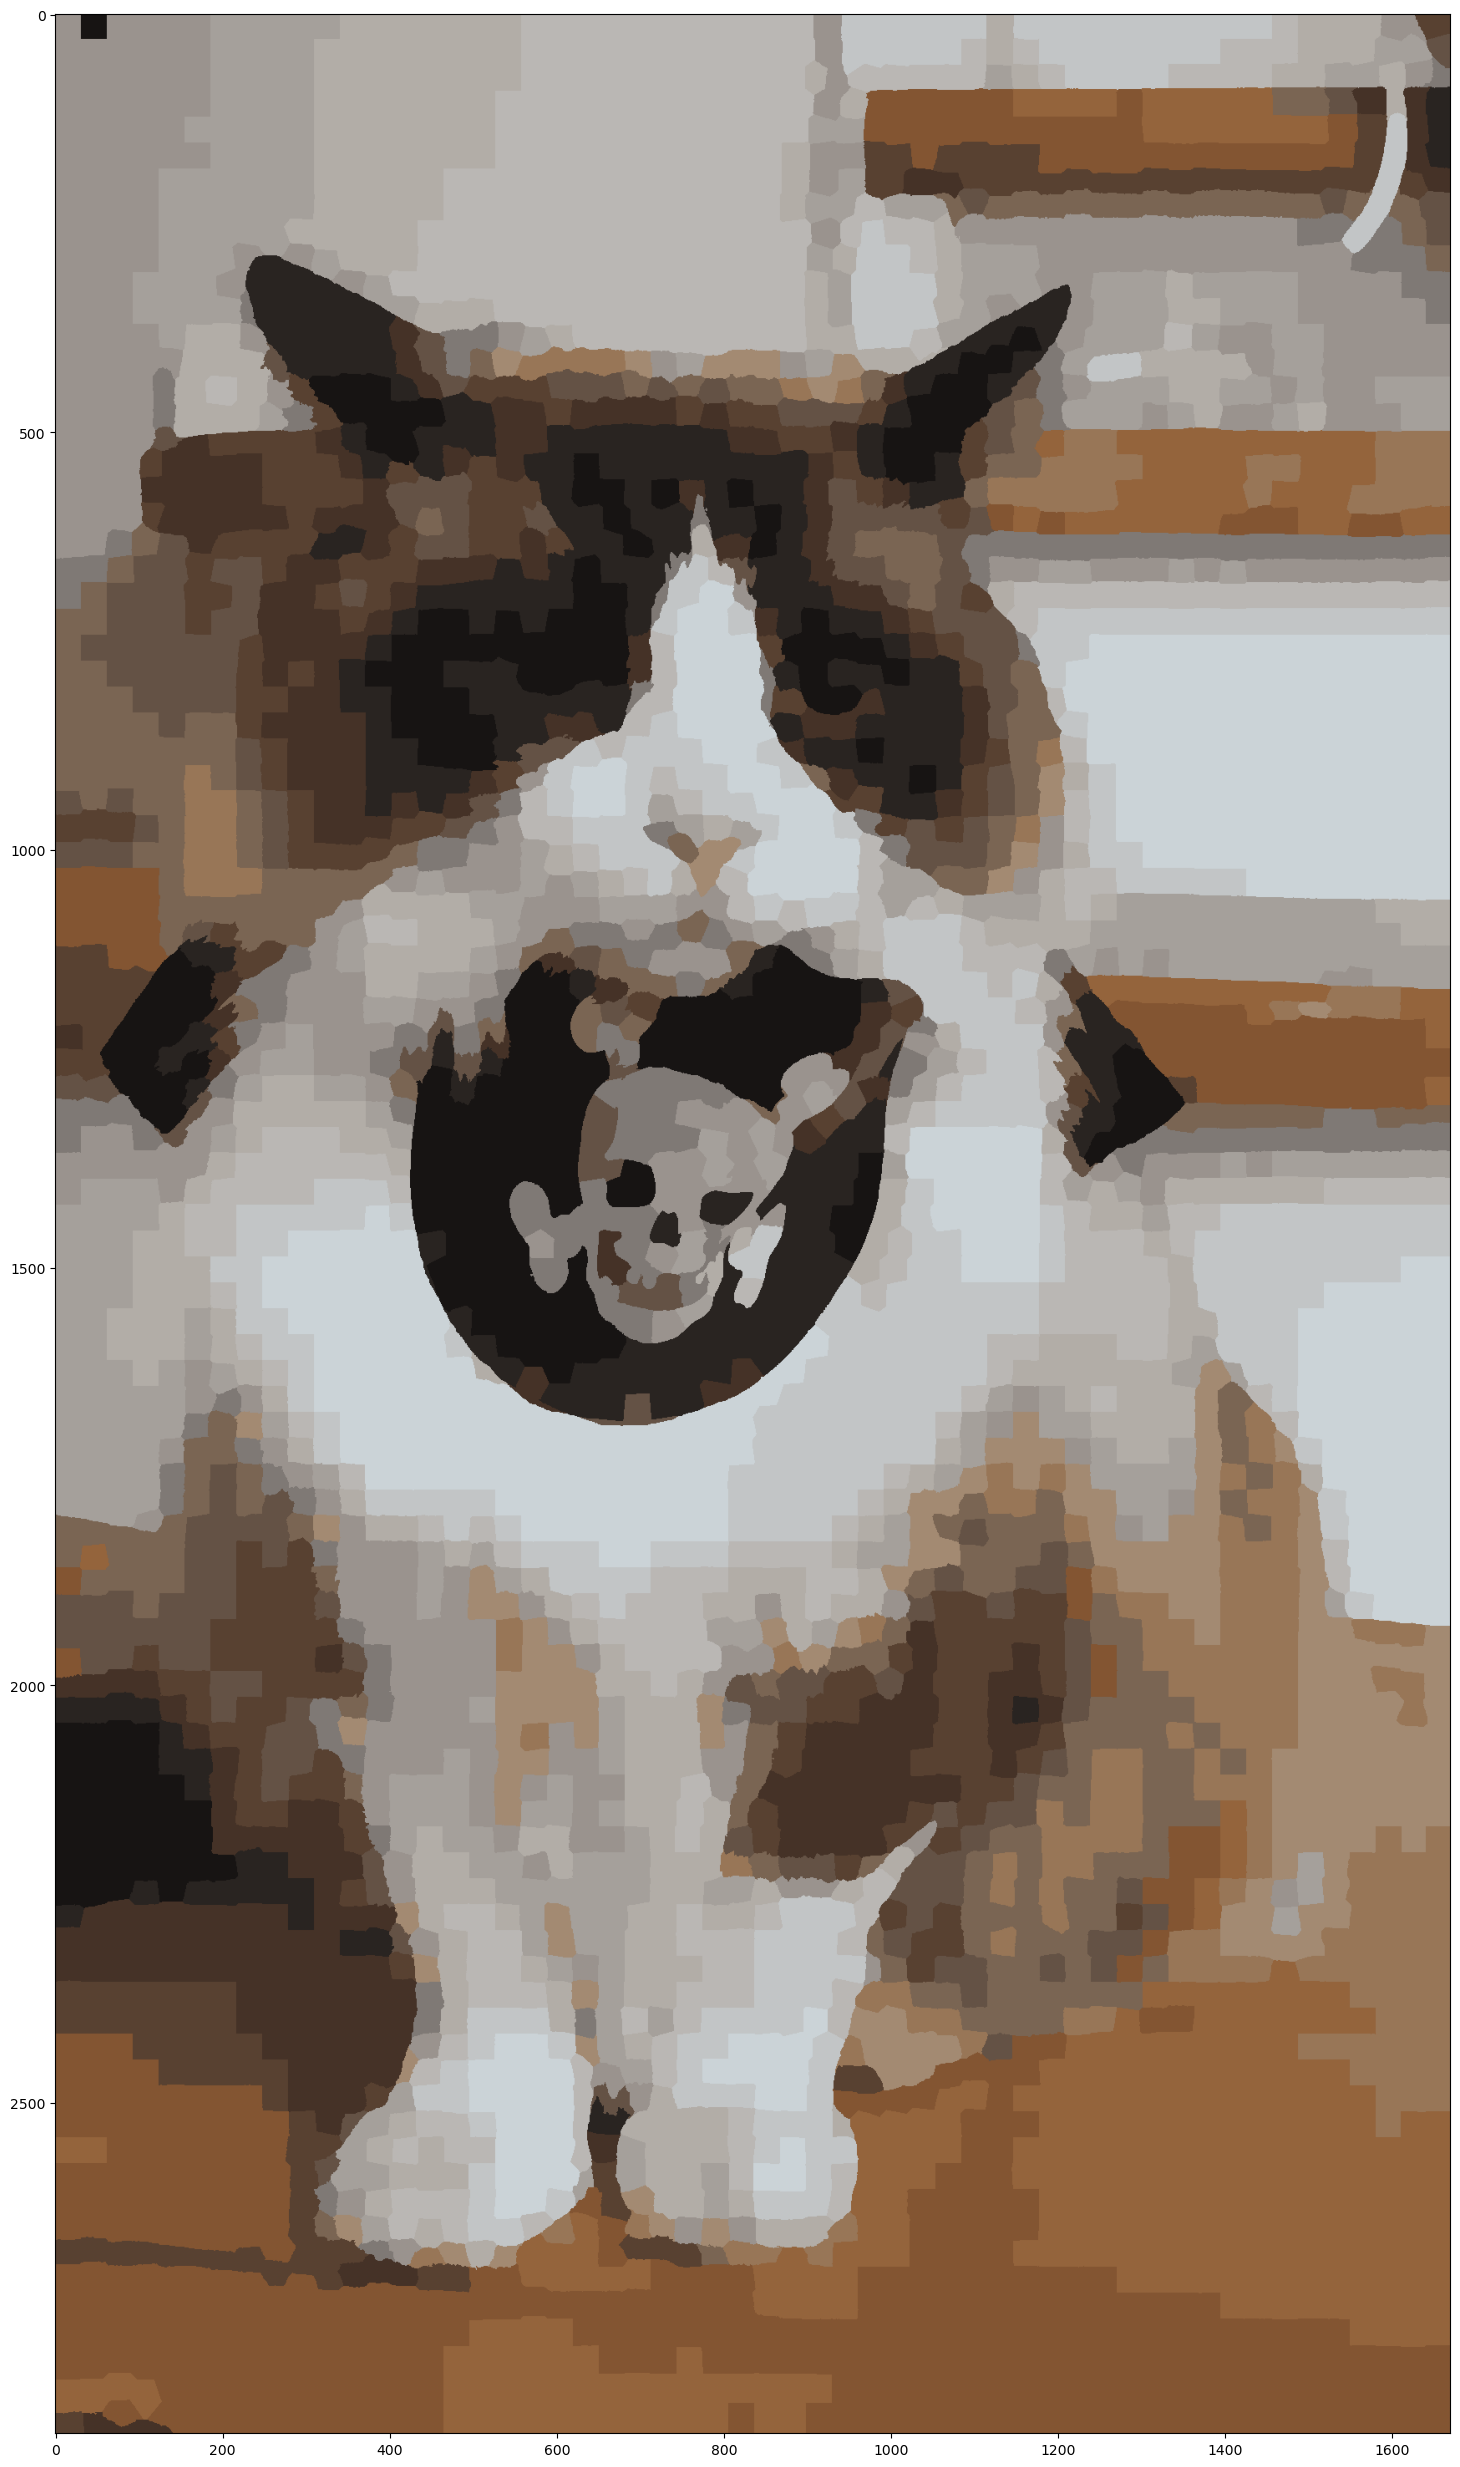

In [64]:
plt.figure(figsize=(18, 32))
plt.imshow(result_image)

In [72]:
image_shape = result_image.shape
borders = np.zeros((image_shape[0], image_shape[1]))

# Vertical
for i in range(image_shape[0]):
    for j in range(image_shape[1] - 1):
        if not np.array_equal(result_image[i][j], result_image[i][j + 1]):
            borders[i][j] = 1

# Horizontal
for i in range(image_shape[0] - 1):
    for j in range(image_shape[1]):
        if not np.array_equal(result_image[i][j], result_image[i + 1][j]):
            borders[i][j] = 1

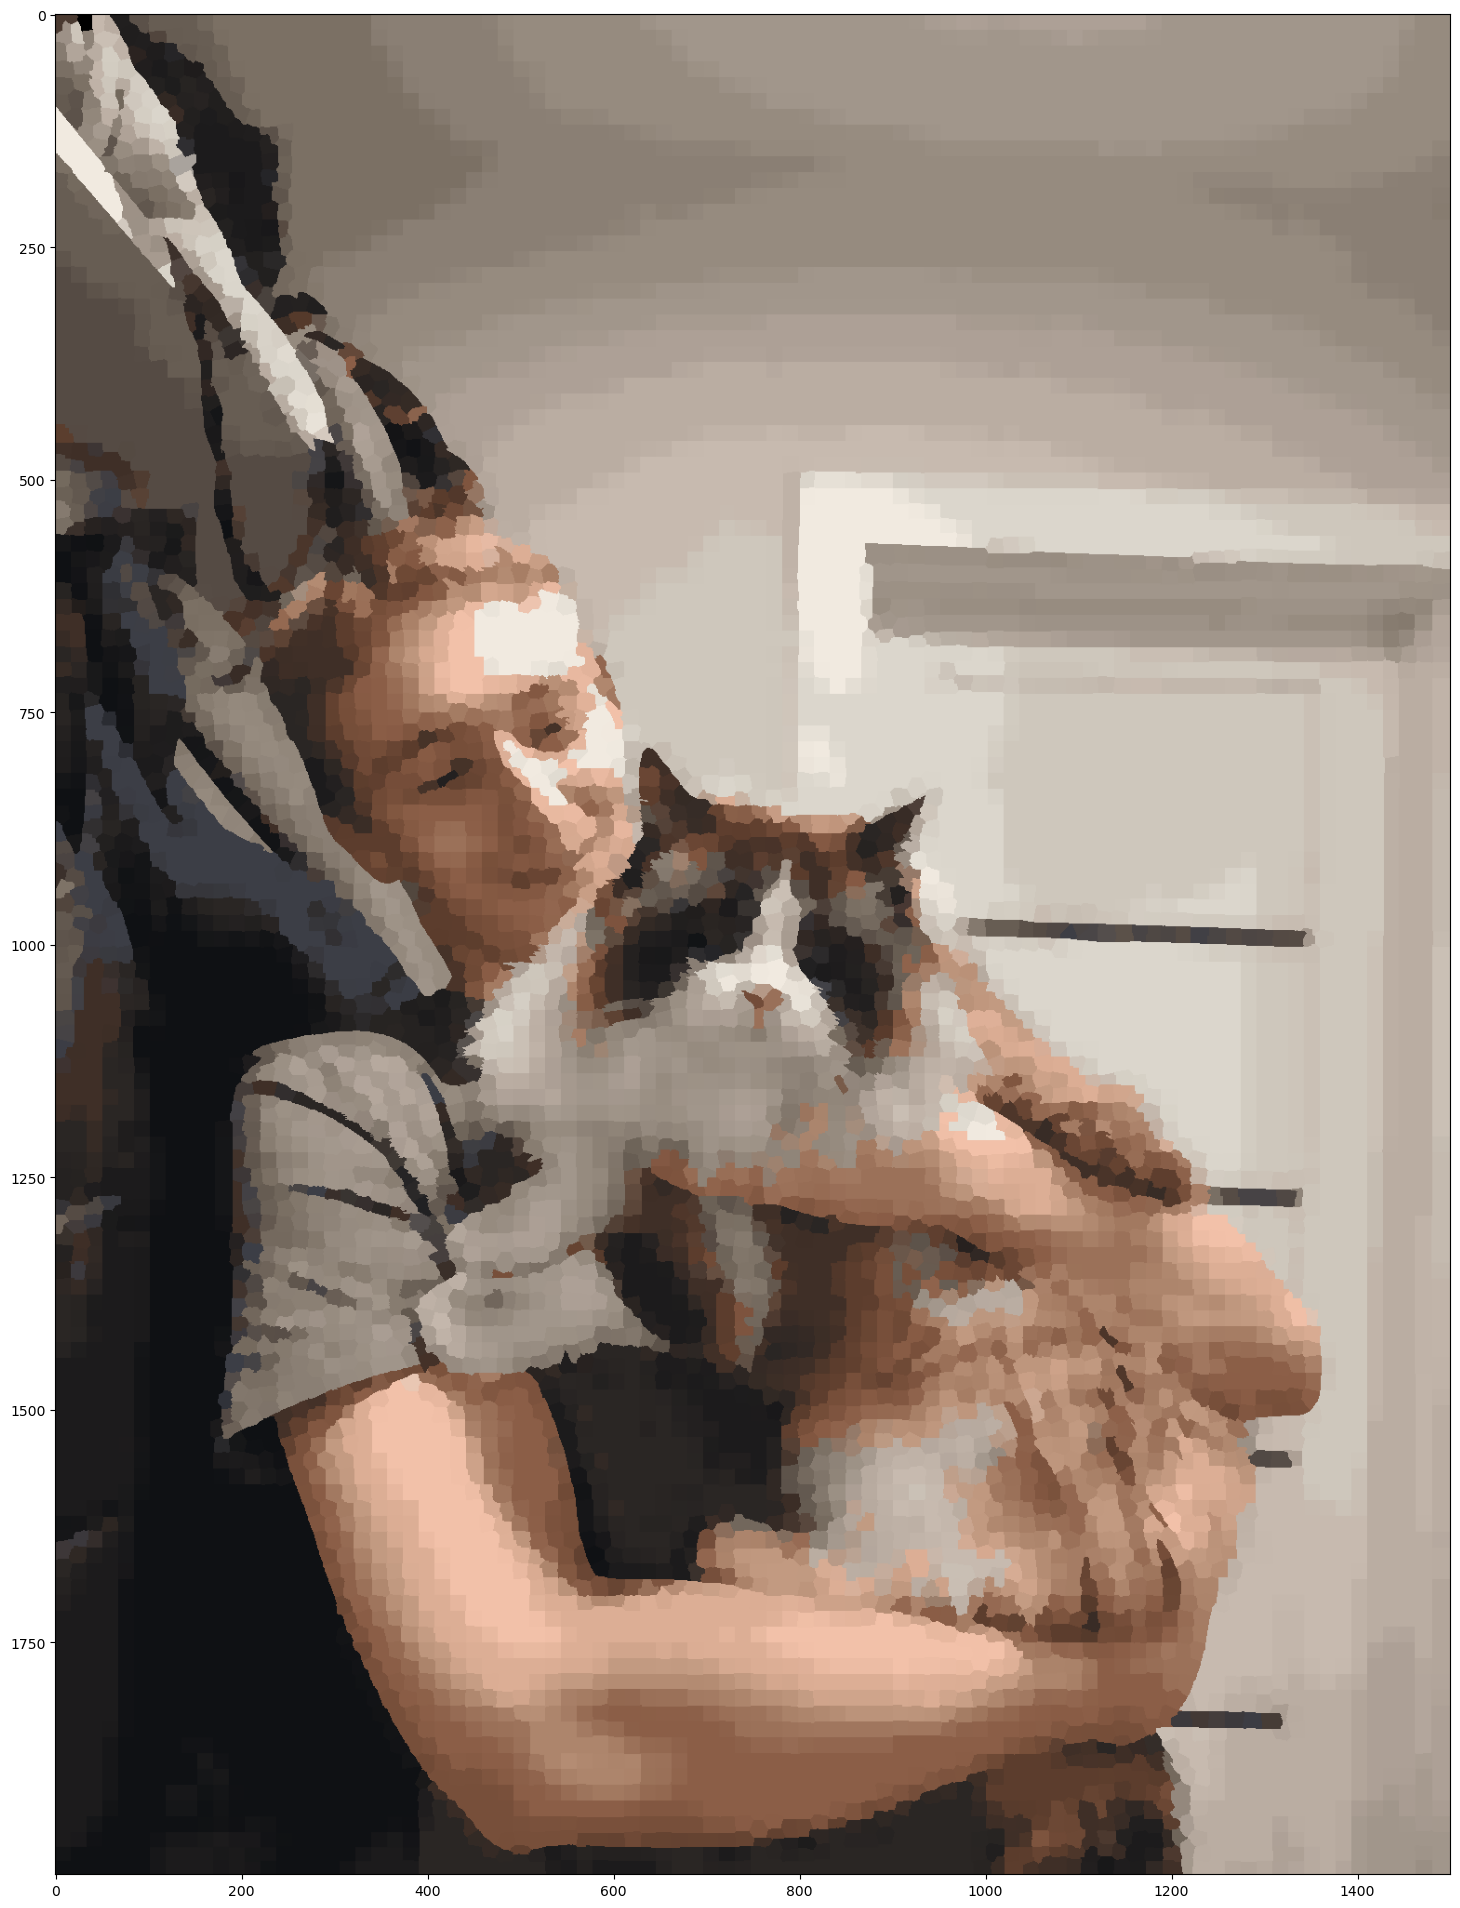

In [38]:
labels1 = segmentation.slic(result_image, compactness=30, n_segments=10000, start_label=0)
out1 = color.label2rgb(labels1, result_image, kind='avg', bg_label=1)

plt.figure(figsize=(18, 32))
plt.imshow(out1)

In [ ]:
import pandas as pd
import ast

paints = pd.read_csv("paints.csv")
paint_names = np.array(paints['paint_name'])
rgbs = np.array([ast.literal_eval(rgb) for rgb in paints['rgb']])

In [66]:
colors = return_colors(result_image)

In [67]:
len(colors)

17

In [ ]:
# Find the closest paint colors to the image colors
closest_paint_colors = find_closest_colors(colors, rgbs)

# Display the results
for i, color in enumerate(closest_paint_colors):
    print(f"Closest paint color to image color {colors[i]} is {color} = {paint_names[np.where(rgbs == color)[0][0]]}")

# trzeba dorobić coś takiego żeby szukało od najczęściej występujących kolorów i jak się powtarzają do żeby dopiero drugi najbliższy kolor, potem trzeci itd.

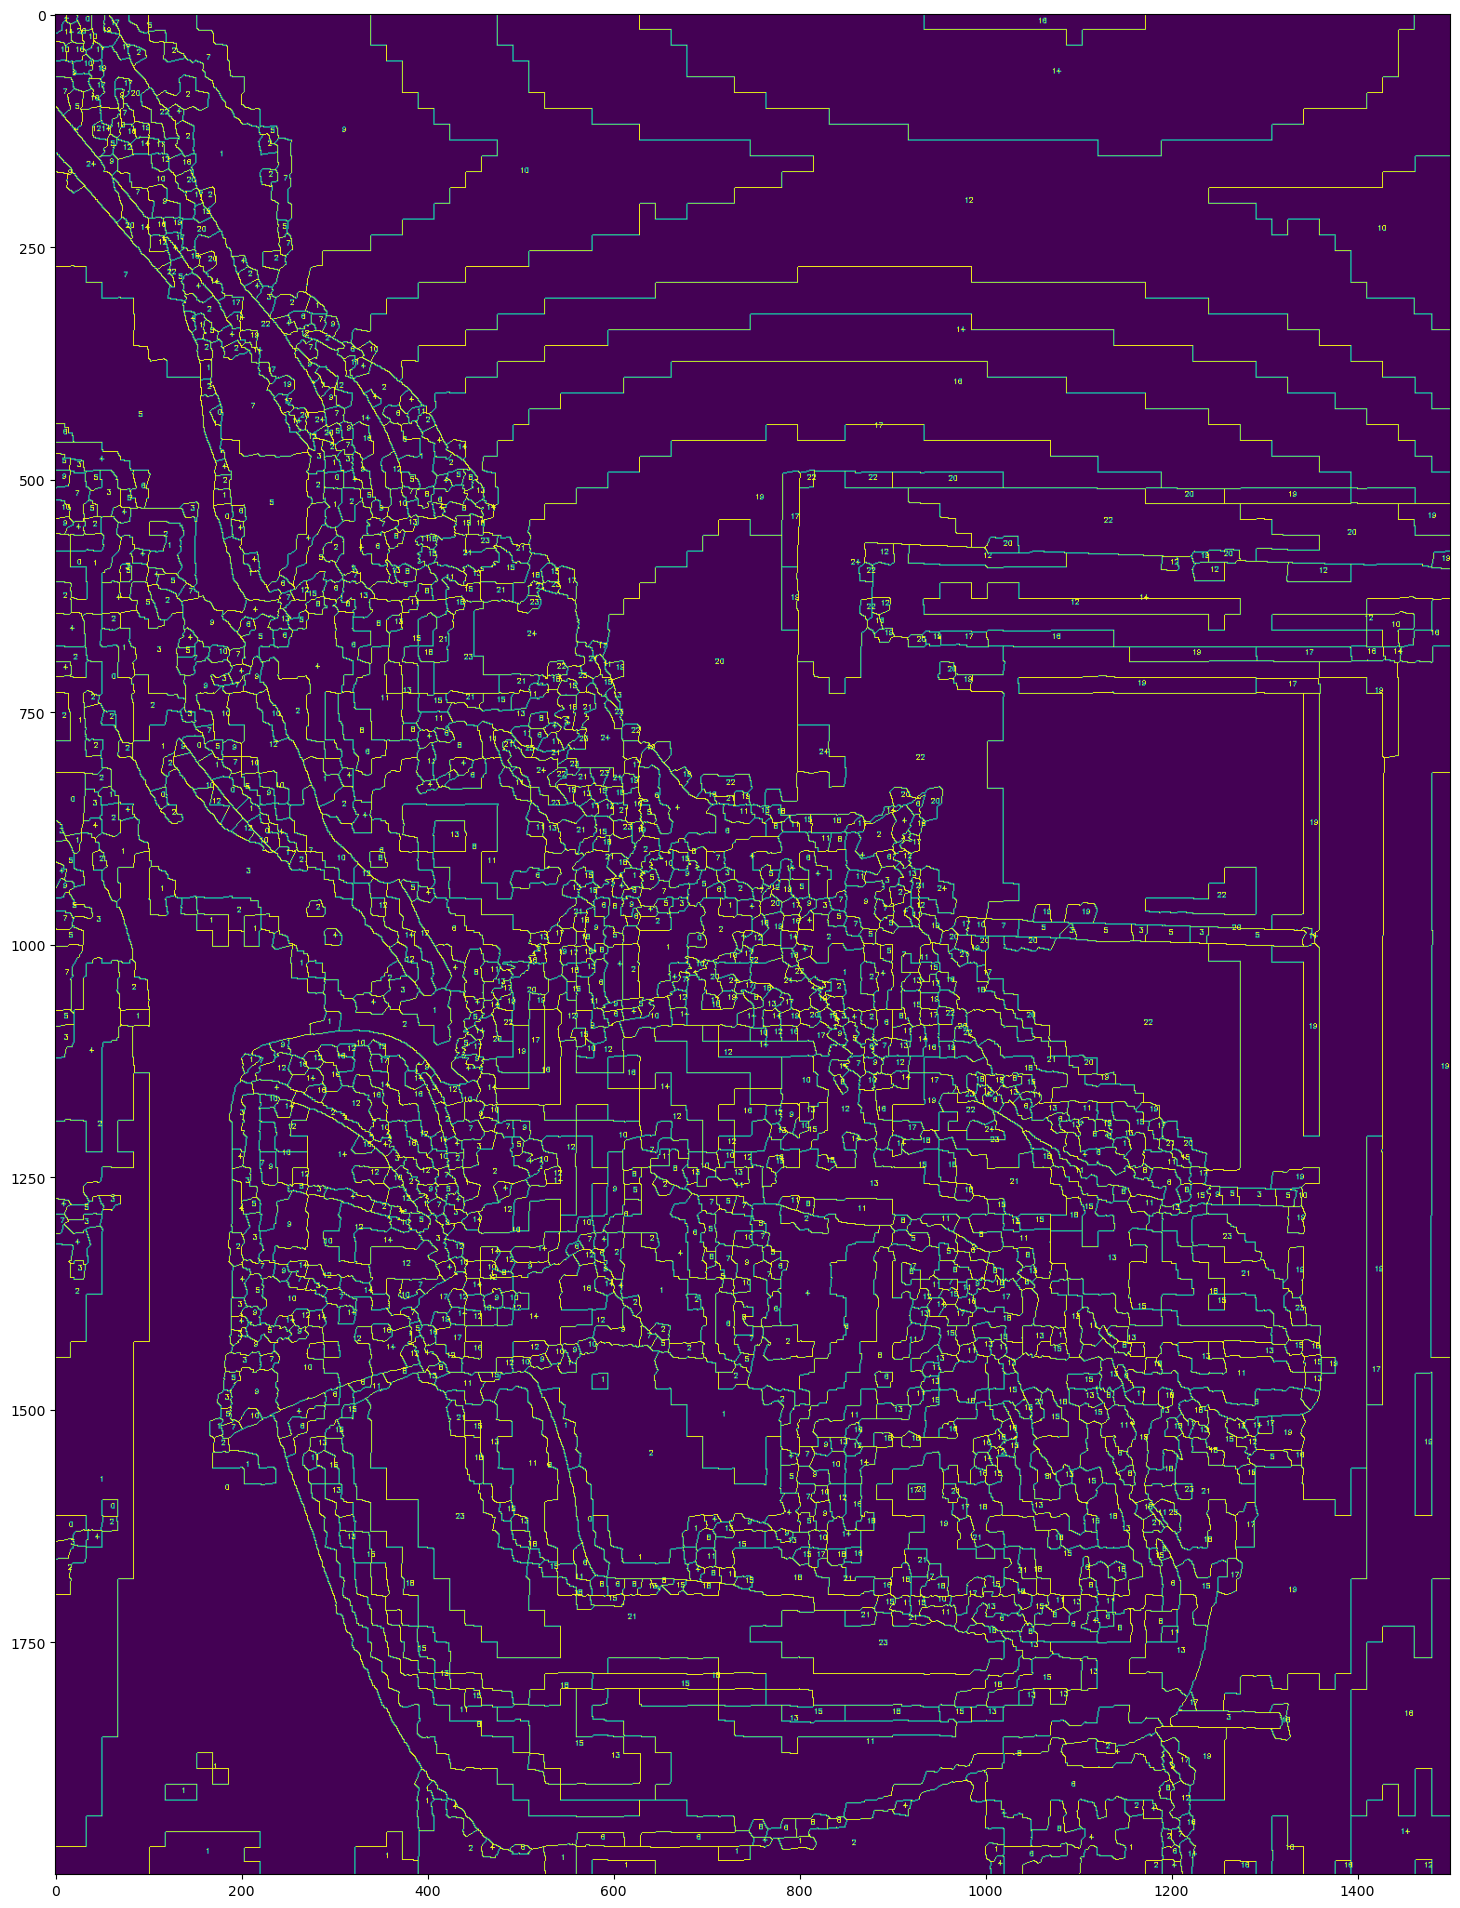

In [69]:
# Prepare the image for drawing (convert single channel mask to BGR)
borders_with_numbers = borders * 255

# Assuming 'result_image' is your segmented image and 'colors' contains the colors you are interested in
for i, color in enumerate(colors):
    # Create a mask for the current color
    mask = cv2.inRange(result_image, color, color)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Calculate the centroid of the contour for placing text
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
        else:
            # Avoid division by zero
            cx, cy = 0, 0

        # Minimum enclosing circle to ensure text fits within the contour
        (x, y), radius = cv2.minEnclosingCircle(contour)
        radius = int(radius)

        # Define text and font
        text = f"{i}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.25
        font_color = (255, 255, 255)  # white text

        # Place text in the center of the contour
        cv2.putText(borders_with_numbers, text, (cx, cy), font, font_scale, font_color, 1, cv2.LINE_AA)

plt.figure(figsize=(18, 32))
plt.imshow(borders_with_numbers)

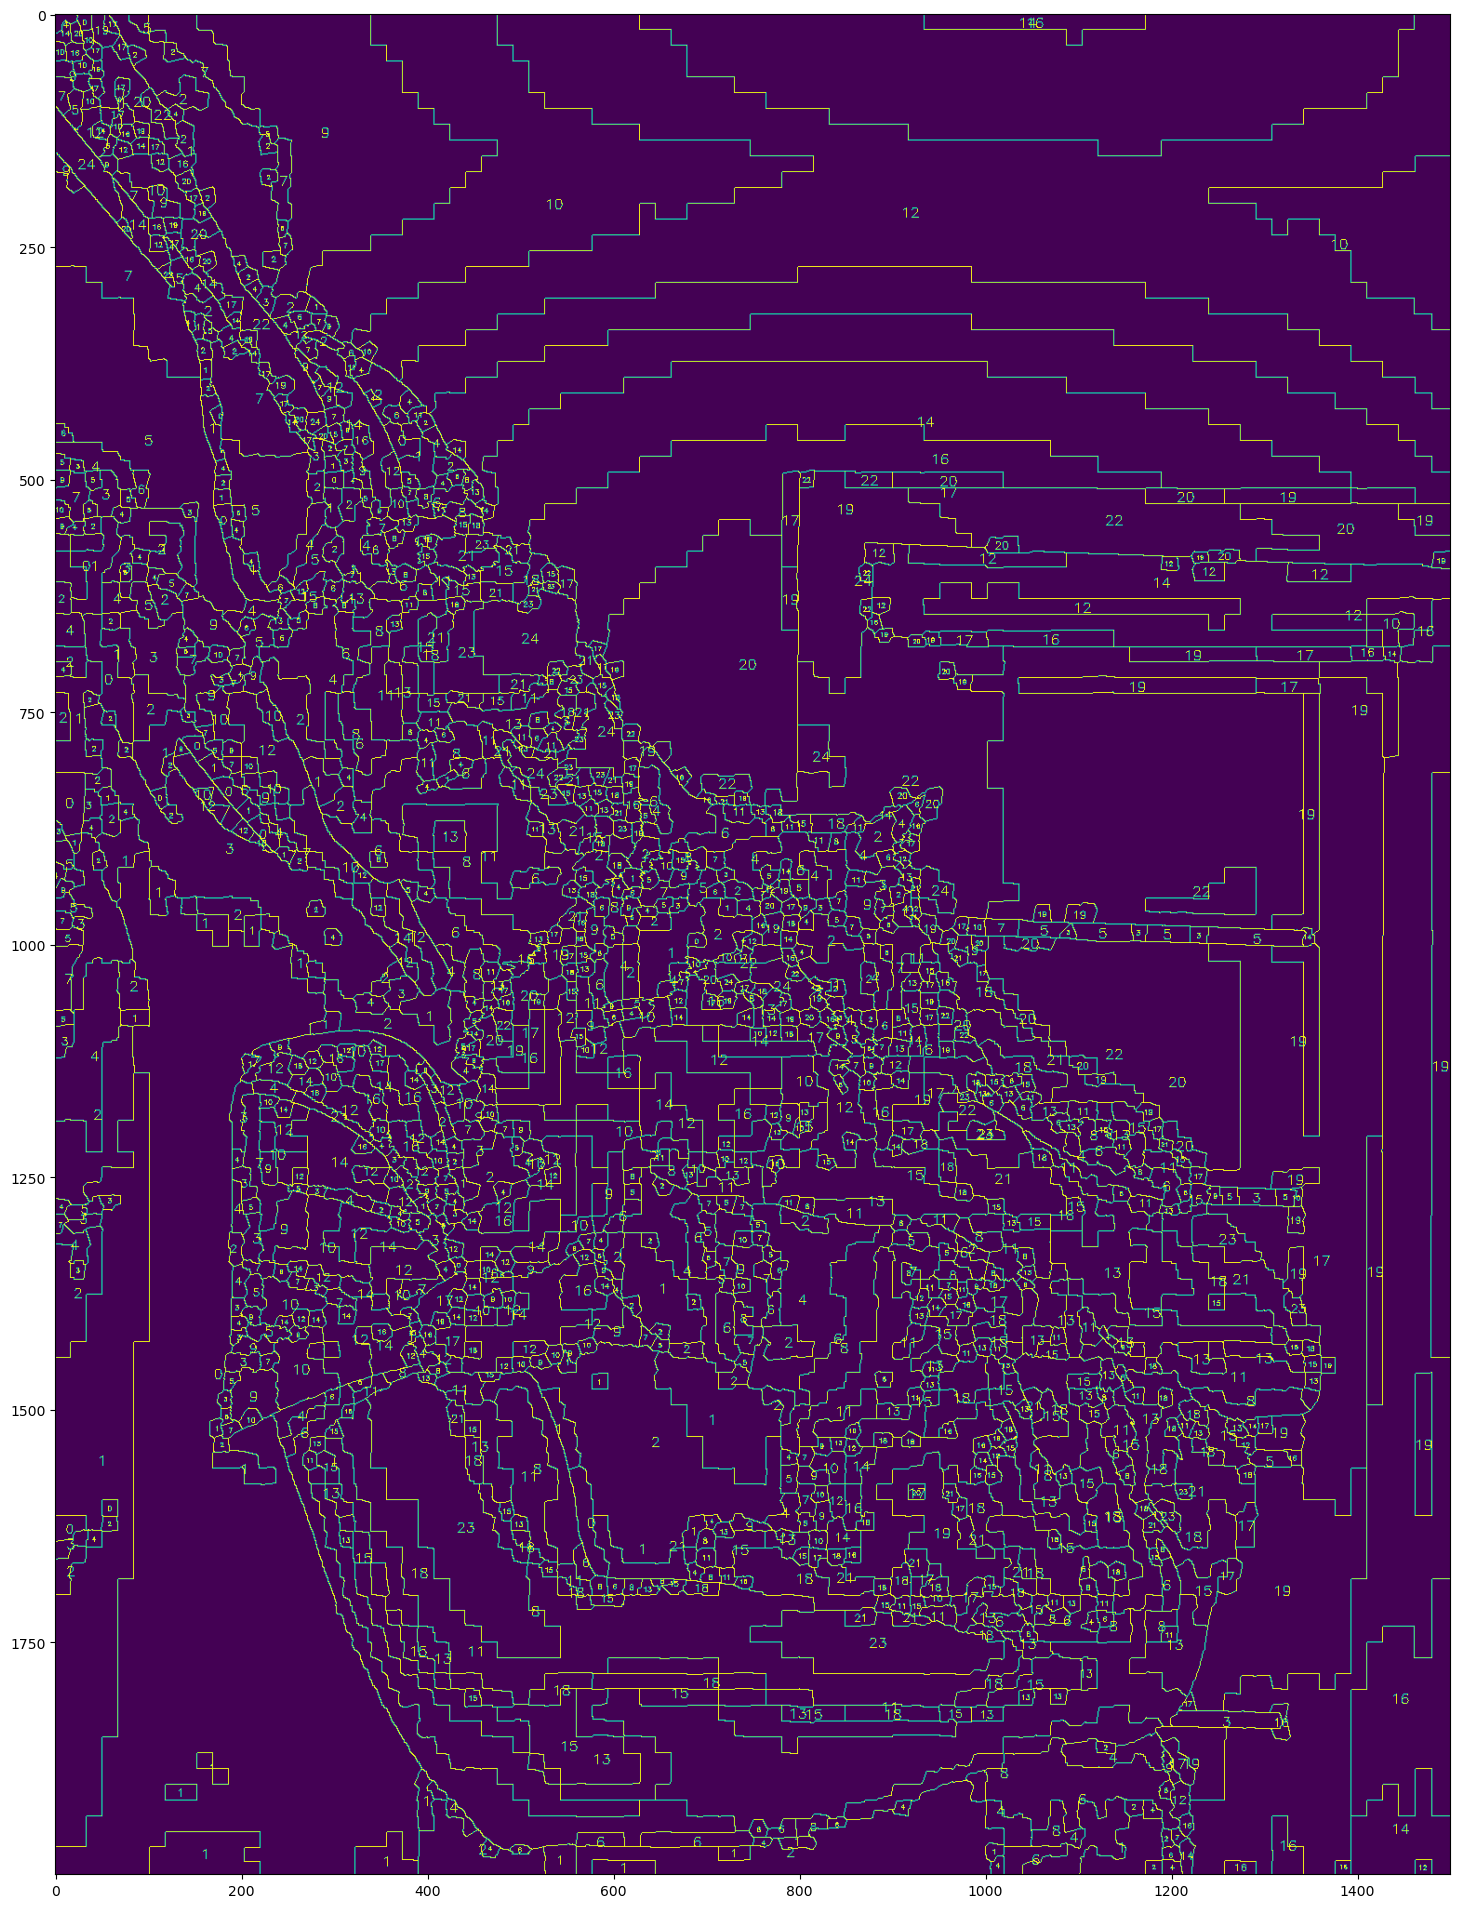

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Prepare the image for drawing (convert single channel mask to BGR if necessary)
borders_with_numbers = borders * 255

for i, color in enumerate(colors):
    # Create a mask for the current color
    mask = cv2.inRange(result_image, color, color)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Calculate the minimum enclosing circle for the contour
        (x, y), radius = cv2.minEnclosingCircle(contour)

        # Adjust text size based on the radius
        if radius > 0:  # Ensure the radius is positive
            font_scale = min(radius / 50, 0.5)  # Adjust font size based on radius, but limit to a maximum
        else:
            continue  # Skip drawing text if radius is zero

        # Convert circle center to integer coordinates
        cx, cy = int(x), int(y)

        # Define text and font
        text = f"{i}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_color = (255, 255, 255)  # white text

        # Place text at the circle's center
        text_size = cv2.getTextSize(text, font, font_scale, 1)[0]
        text_x = cx - text_size[0] // 2
        text_y = cy + text_size[1] // 2
        cv2.putText(borders_with_numbers, text, (text_x, text_y), font, font_scale, font_color, 1, cv2.LINE_AA)

plt.figure(figsize=(18, 32))
plt.imshow(borders_with_numbers)


# Tu się dobre zaczynają

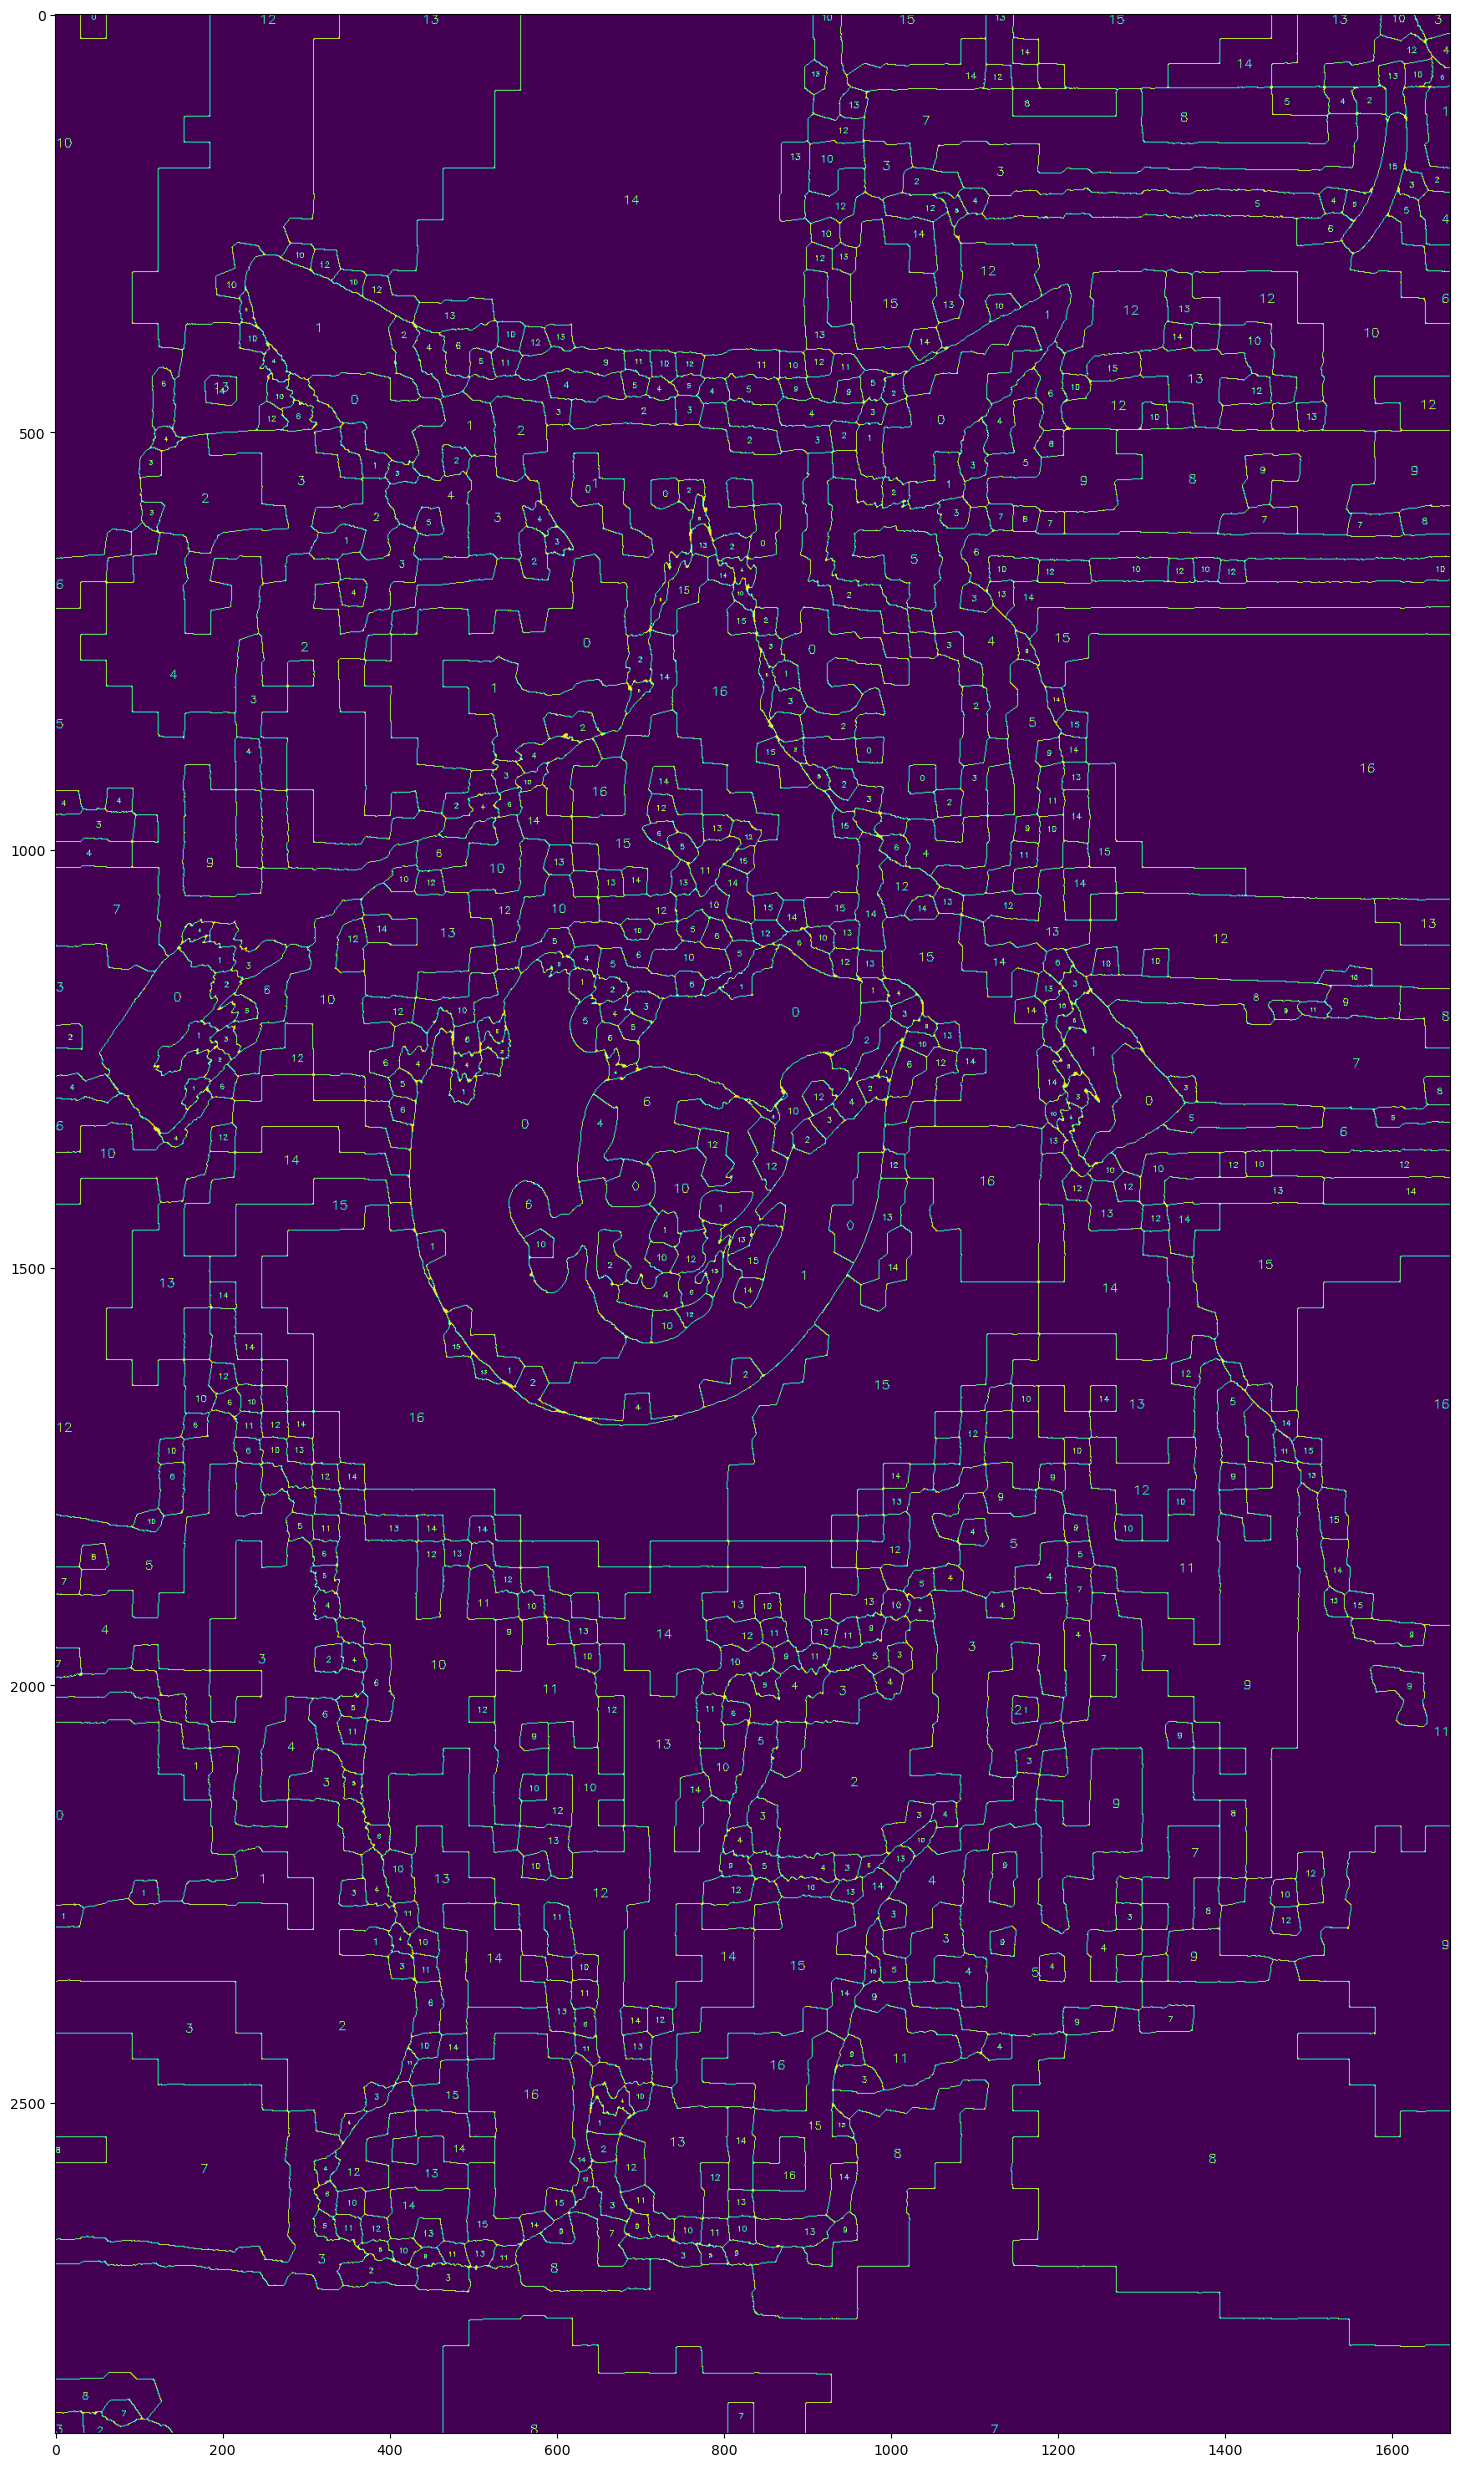

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Prepare the image for drawing (convert single channel mask to BGR if necessary)
borders = skimage.morphology.binary_closing(borders)
borders_with_numbers = borders * 255


for i, color in enumerate(colors):
    # Create a mask for the current color
    mask = cv2.inRange(result_image, color, color)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Calculate the distance transform of the binary image within the contour
        mask_contour = np.zeros_like(mask)
        cv2.drawContours(mask_contour, [contour], 0, 255, thickness=cv2.FILLED)
        dist_transform = cv2.distanceTransform(mask_contour, cv2.DIST_L2, 3)

        # Find the indices of the maximum value in the distance transform
        max_idx = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)

        # Center of the largest inscribed circle
        cx, cy = max_idx[::-1]  # Reverse the order for (x, y)

        # Adjust text size based on the radius
        max_val = dist_transform[max_idx]
        font_scale = min(max_val / 50, 0.5)  # Adjust font size based on distance, but limit to a maximum

        # Define text and font
        text = f"{i}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_color = (255, 255, 255)  # white text

        # Place text at the circle's center
        text_size = cv2.getTextSize(text, font, font_scale, 1)[0]
        text_x = max(0, min(cx - text_size[0] // 2, borders_with_numbers.shape[1] - text_size[0]))
        text_y = max(text_size[1], min(cy + text_size[1] // 2, borders_with_numbers.shape[0]))
        cv2.putText(borders_with_numbers, text, (text_x, text_y), font, font_scale, font_color, 1, cv2.LINE_AA)

plt.figure(figsize=(18, 32))
plt.imshow(borders_with_numbers)
plt.show()


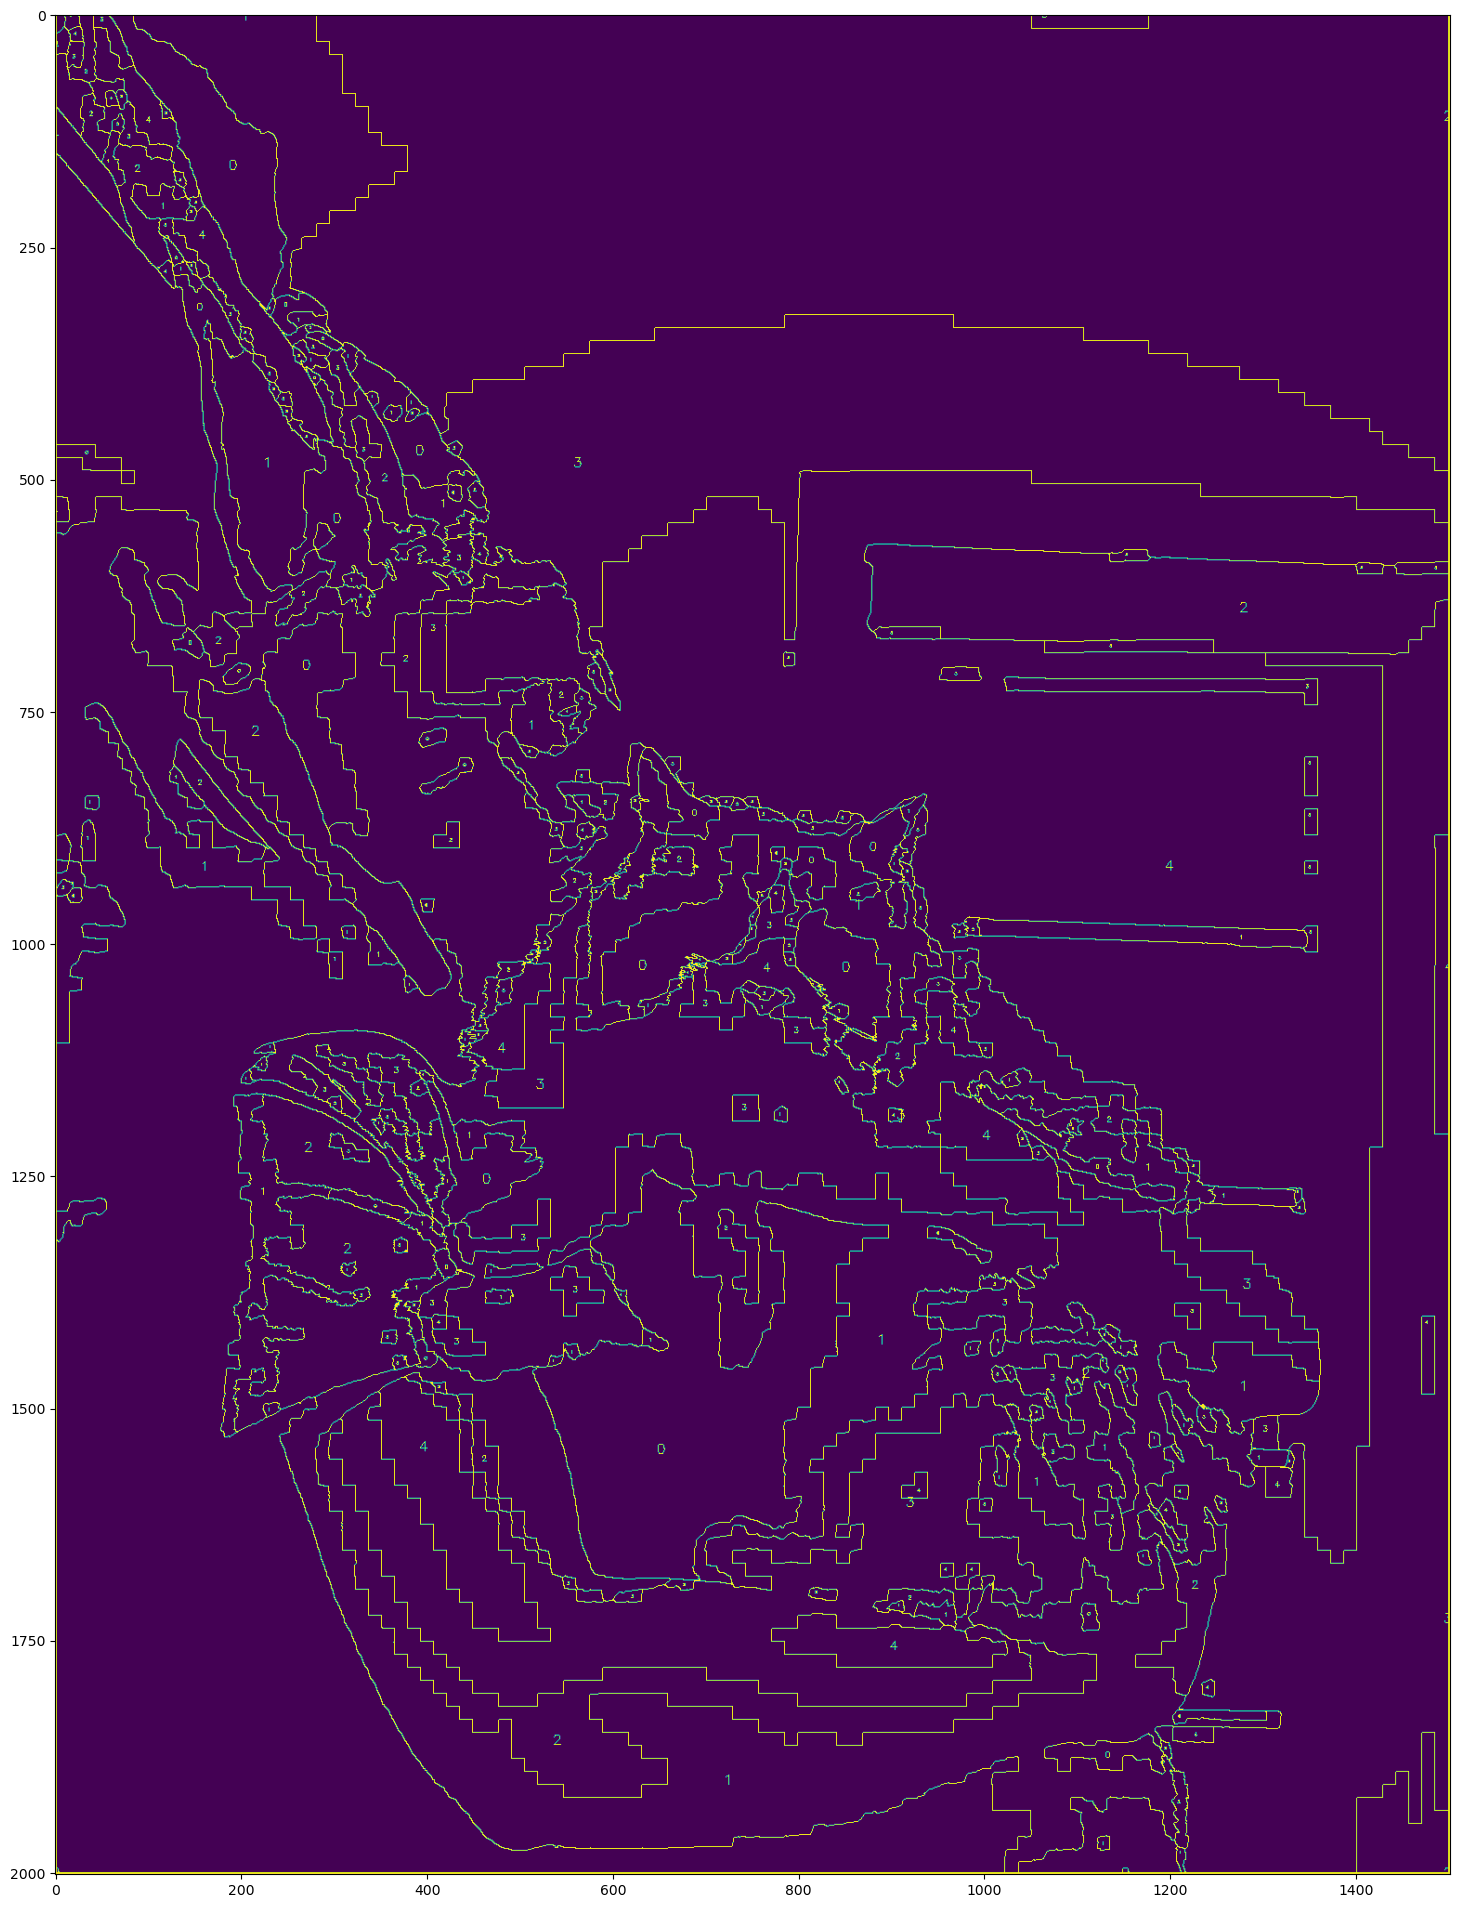

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Prepare the image for drawing (convert single channel mask to BGR if necessary)
# Add ones to the top and bottom borders

borders_with_numbers = borders * 255

for i, color in enumerate(colors):
    # Create a mask for the current color
    mask = cv2.inRange(result_image, color, color)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Calculate the distance transform of the binary image within the contour
        mask_contour = np.zeros_like(mask)
        cv2.drawContours(mask_contour, [contour], 0, 255, thickness=cv2.FILLED)
        dist_transform = cv2.distanceTransform(mask_contour, cv2.DIST_L2, 3)

        # Find the indices of the maximum value in the distance transform
        max_idx = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)

        # Center of the largest inscribed circle
        cx, cy = max_idx[::-1]  # Reverse the order for (x, y)

        # Adjust text size based on the radius
        max_val = dist_transform[max_idx]
        font_scale = min(max_val / 50, 0.5)  # Adjust font size based on distance, but limit to a maximum

        # Define text and font
        text = f"{i}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_color = (255, 255, 255)  # white text

        # Place text at the circle's center
        text_size = cv2.getTextSize(text, font, font_scale, 1)[0]
        text_x = cx - text_size[0] // 2
        text_y = cy + text_size[1] // 2
        cv2.putText(borders_with_numbers, text, (text_x, text_y), font, font_scale, font_color, 1, cv2.LINE_AA)

plt.figure(figsize=(18, 32))
plt.imshow(borders_with_numbers)
plt.show()
